<a href="https://colab.research.google.com/github/Yolantele/ML-data-clasifier/blob/master/NL_SpaCy_ML_Classifier_for_Waste_Data_Augmentation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Dutch Waste Data Classification and Augmentation** 

Performs text analysis operations with spaCy and  builds machine learning model with scikit-learn


scikit-learn :
https://scikit-learn.org/stable/

spaCy Language Models:
https://spacy.io/usage/models

scikit-learn + Spacy : 
https://www.dataquest.io/blog/tutorial-text-classification-in-python-using-spacy/

Eural Code reference: 
https://eur-lex.europa.eu/legal-content/EN/TXT/?uri=CELEX:02000D0532-20150601


In [ ]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [ ]:
# mount data from drive
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
!pip install -U spacy
!pip install pandas
!python -m spacy download nl_core_news_md

## **Loading Languages model and Data Frames**

In [5]:
import spacy
import pandas as pd
from spacy.lang.nl import Dutch
import nl_core_news_md
spacy.prefer_gpu()

nlp = nl_core_news_md.load #medium size lang model (smae results as large size lanf model)

In [8]:
path = '/content/drive/My Drive/data/'

# train data frames:
materials = pd.read_csv(path + '/nlMaterialData.csv')


# test data frames:
materials_test = pd.read_csv(path + '/nlWithoutMaterialData.csv')

# set data frame: 
df = materials


df.shape
df.info()
df.head()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3700 entries, 0 to 3699
Data columns (total 24 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   reason            21 non-null     object 
 1   origin            50 non-null     object 
 2   color             52 non-null     object 
 3   state             722 non-null    object 
 4   size              74 non-null     object 
 5   consistency       3551 non-null   object 
 6   otherCode         576 non-null    object 
 7   material4         27 non-null     object 
 8   material3         489 non-null    object 
 9   material2         984 non-null    object 
 10  material          3700 non-null   object 
 11  mType             887 non-null    object 
 12  composite2        21 non-null     object 
 13  composite1        1374 non-null   object 
 14  cType             247 non-null    object 
 15  indirectProduct   2723 non-null   object 
 16  directProduct     648 non-null    object 


,reason,origin,color,state,size,consistency,otherCode,material4,material3,material2,material,mType,composite2,composite1,cType,indirectProduct,directProduct,pType,mixedOrPure,cleanOrDirty,euralDescription,euralCode,description,/0
0,afgekeurd,NaN,NaN,NaN,NaN,vast,NaN,NaN,NaN,NaN,organisch materiaal,NaN,NaN,GFT,NaN,GFT,NaN,NaN,gemengd,NaN,afval van dierlijke weefsels,20102,GFT Afgekeurd,NaN
1,NaN,NaN,NaN,NaN,NaN,vast,categorie 3,NaN,NaN,NaN,organisch materiaal,NaN,NaN,GFT,NaN,GFT,NaN,NaN,puur,NaN,afval van dierlijke weefsels,20102,GFT Categorie 3,NaN
2,NaN,NaN,NaN,NaN,NaN,vast,200,NaN,NaN,NaN,hout,stobben,NaN,NaN,NaN,hout,NaN,NaN,puur,NaN,afval van plantaardige weefsels,20103,200 Boomstobben,NaN
3,NaN,NaN,NaN,NaN,NaN,vast,NaN,NaN,NaN,NaN,gras,bermgras,NaN,NaN,NaN,gras,NaN,NaN,puur,NaN,afval van plantaardige weefsels,20103,BERMGRAS,NaN
4,NaN,NaN,NaN,NaN,NaN,vast,NaN,NaN,NaN,NaN,organisch materiaal,blauwmaanzaad,NaN,NaN,NaN,organisch materiaal,NaN,NaN,puur,NaN,afval van plantaardige weefsels,20103,BLAUWMAANZAAD TER VERNIETIGING,NaN


## **Tokening the Data With spaCy**

creating a custom tokenizer function using spaCy to automatically strip unnecesarry information like stopwords and punctuation

In [11]:
from spacy.lang.nl.stop_words import STOP_WORDS


parser = Dutch()
punctuations = '''!()-[]{};:'"\,<>./?@#$%^&*_~'''
stopwords = STOP_WORDS
# stopwords = [] # in some cases stopwords help (increase accuracy by 1%)

def spacy_tokenize(sentence):
    # Creating our token object, which is used to create documents with linguistic annotations.
    sentence = sentence.strip().lower()
    mytokens = parser(sentence)

    # Lemmatizing each token and converting each token into lowercase
    mytokens = [ word.lemma_.lower().strip() if word.lemma_ != "-PRON-" else word.lower_ for word in mytokens  ]

    # Removing stop words
    mytokens = [ word for word in mytokens if word not in punctuations and word not in stopwords]

    # return preprocessed list of tokens
    return mytokens


###**Vectorization Feature Engineering, TF-IDF, Bag of Words and N-grams**

Classifying text we end up with text snippets with their respective labels. But in machine learning model we need to convert into numeric representation (vector coordinates)

- **TF-IDF -Term Frequency-Inverse Document Frequency**- simply a way of normalizing our Bag of Words(BoW) by looking at each word’s frequency in comparison to the document frequency.

- **N-grams** - combinations of adjacent words in a given text. For example "who will win"
 1. when n = 1, becomes "who", "will", "win",
 2. when n = 2 , becomes "who will", "will win" etc. 

In [12]:
from sklearn.feature_extraction.text import CountVectorizer,TfidfVectorizer
from sklearn.base import TransformerMixin

bow_vector = CountVectorizer(tokenizer=spacy_tokenize, ngram_range=(1,1))

tfidf_vector = TfidfVectorizer(tokenizer=spacy_tokenize)

print(bow_vector)
print(tfidf_vector)

CountVectorizer(analyzer='word', binary=False, decode_error='strict',
                dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
                lowercase=True, max_df=1.0, max_features=None, min_df=1,
                ngram_range=(1, 1), preprocessor=None, stop_words=None,
                strip_accents=None, token_pattern='(?u)\\b\\w\\w+\\b',
                tokenizer=<function spacy_tokenize at 0x7f977ae737b8>,
                vocabulary=None)
TfidfVectorizer(analyzer='word', binary=False, decode_error='strict',
                dtype=<class 'numpy.float64'>, encoding='utf-8',
                input='content', lowercase=True, max_df=1.0, max_features=None,
                min_df=1, ngram_range=(1, 1), norm='l2', preprocessor=None,
                smooth_idf=True, stop_words=None, strip_accents=None,
                sublinear_tf=False, token_pattern='(?u)\\b\\w\\w+\\b',
                tokenizer=<function spacy_tokenize at 0x7f977ae737b8>,
                use_idf=Tru

## **Splitting The Data into Training and Validation Sets**


### material classiciation

In [66]:
from sklearn.model_selection import train_test_split


X = df['description'] # the features we want to analyze
ylabels = df['material'] # the labels, or answers, we want to test against

X_train, X_test, y_train, y_test = train_test_split(X, ylabels, test_size=0.3)

print(X)

0                                   GFT Afgekeurd
1                                 GFT Categorie 3
2                                 200 Boomstobben
3                                        BERMGRAS
4                  BLAUWMAANZAAD TER VERNIETIGING
                          ...                    
3692                                   groenafval
3694                              plantaardig vet
3695                                  fruitresten
3697    consumptie ongeschikt mat. (palmvetzuren)
3698                                      zetmeel
Name: description, Length: 3286, dtype: object


### mixed or pure classification

In [17]:
from sklearn.model_selection import train_test_split


df = df[df['mixedOrPure'].notna()]

X = df['description'] # the features we want to analyze
ylabels = df['mixedOrPure'] # the labels, or answers, we want to test against

X_train, X_test, y_train, y_test = train_test_split(X, ylabels, test_size=0.3)

print(X)

0                                   GFT Afgekeurd
1                                 GFT Categorie 3
2                                 200 Boomstobben
3                                        BERMGRAS
4                  BLAUWMAANZAAD TER VERNIETIGING
                          ...                    
3692                                   groenafval
3694                              plantaardig vet
3695                                  fruitresten
3697    consumptie ongeschikt mat. (palmvetzuren)
3698                                      zetmeel
Name: description, Length: 3286, dtype: object


### consistency classification

In [21]:
from sklearn.model_selection import train_test_split


df = df[df['consistency'].notna()]

X = df['description'] # the features we want to analyze
ylabels = df['consistency'] # the labels, or answers, we want to test against

X_train, X_test, y_train, y_test = train_test_split(X, ylabels, test_size=0.3)

print(X)

0                                           GFT Afgekeurd
1                                         GFT Categorie 3
2                                         200 Boomstobben
3                                                BERMGRAS
4                          BLAUWMAANZAAD TER VERNIETIGING
                              ...                        
3691    geslagen aluminium, oude en nieuwe aluminium p...
3692                                           groenafval
3694                                      plantaardig vet
3697            consumptie ongeschikt mat. (palmvetzuren)
3698                                              zetmeel
Name: description, Length: 3215, dtype: object


## **Creating a Pipeline and Generating the Model**

###we’ll create a pipeline with three components: a **cleaner, a vectorizer, and a classifier**. 

- The cleaner uses our predictors class object to clean and preprocess the text. 

- The vectorizer uses countvector objects to create the bag of words matrix for our text. 

- The classifier is an object that performs the logistic regression to classify the sentiments.

In [22]:
# Custom transformer using spaCy
class predictors(TransformerMixin):
    def transform(self, X, **transform_params):
        # Cleaning Text
        return [clean_text(text) for text in X]

    def fit(self, X, y=None, **fit_params):
        return self

    def get_params(self, deep=True):
        return {}


def clean_text(text):
    # Removing spaces and converting text into lowercase
    return text.strip().lower()

In [23]:
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline

# Creating Logistic Regression Classifier
classifier = LogisticRegression()

# Create pipeline using Bag of Words (BoW)
model = Pipeline([("cleaner", predictors()),
                 ('vectorizer', bow_vector),
                 ('classifier', classifier)])

# model generation
model.fit(X_train,y_train)

Pipeline(memory=None,
         steps=[('cleaner', <__main__.predictors object at 0x7f9779a91a58>),
                ('vectorizer',
                 CountVectorizer(analyzer='word', binary=False,
                                 decode_error='strict',
                                 dtype=<class 'numpy.int64'>, encoding='utf-8',
                                 input='content', lowercase=True, max_df=1.0,
                                 max_features=None, min_df=1,
                                 ngram_range=(1, 1), preprocessor=None,
                                 stop_words=None, strip_accents=None,
                                 t...\\b\\w\\w+\\b',
                                 tokenizer=<function spacy_tokenize at 0x7f977ae737b8>,
                                 vocabulary=None)),
                ('classifier',
                 LogisticRegression(C=1.0, class_weight=None, dual=False,
                                    fit_intercept=True, intercept_scaling=1,
             

### Save the Trained Model

In [70]:
import pickle
# save the model to disk
filename = path + 'nl_mixed_or_pure_classification_model.sav'
pickle.dump(model, open(filename, 'wb'))
 
loaded_model = pickle.load(open(filename, 'rb'))
result = loaded_model.score(X_test, y_test)

print('loaded model score---', result)

loaded model score--- 0.7860040567951319


### **Model Predictions - Classifications**

In [25]:
from sklearn import metrics

row = 4

# Predicting for a test dataset
predicted = model.predict(X_test)
print('Using validation set:')

print('material description was ----> ', X_test.iloc[row])
print('material predicted is ----->', predicted[row])


# predict using unclassified set
pred = model.predict(materials_test)
print('')
print('Using test set (unclassified):')
print('material description was ----> ', materials_test.iloc[row].description)
print('material predicted is ----->', pred[row])


Using validation set:
material description was ---->  Teerhoudend asfaltgranulaat GA
material predicted is -----> vast

Using test set (unclassified):
material description was ---->  AFVAL VAN DE BOSBOUW
material predicted is -----> vast


### **Model Accuracy Reports**

**Accuracy** refers to the percentage of the total predictions our model makes that are completely correct.

**Precision** describes the ratio of true positives to true positives plus false positives in our predictions.

**Recall** describes the ratio of true positives to true positives plus false negatives in our predictions.


In [26]:

# Model Accuracy Reports

print("Accuracy:",metrics.accuracy_score(y_test, predicted ))
print("Precision:",metrics.precision_score(y_test, predicted, average='weighted'))
print("Recall:",metrics.recall_score(y_test, predicted, average='weighted'))
print( metrics.classification_report(y_test, predicted))

Accuracy: 0.966839378238342
Precision: 0.9491893698813305
Recall: 0.966839378238342
              precision    recall  f1-score   support

      slurry       0.00      0.00      0.00        14
        vast       0.97      1.00      0.98       931
   vloeibaar       0.75      0.15      0.25        20

    accuracy                           0.97       965
   macro avg       0.57      0.38      0.41       965
weighted avg       0.95      0.97      0.95       965



/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


### **Plotting the Classification Outcomes (description and material dependencies)**

UFuncTypeError: ignored

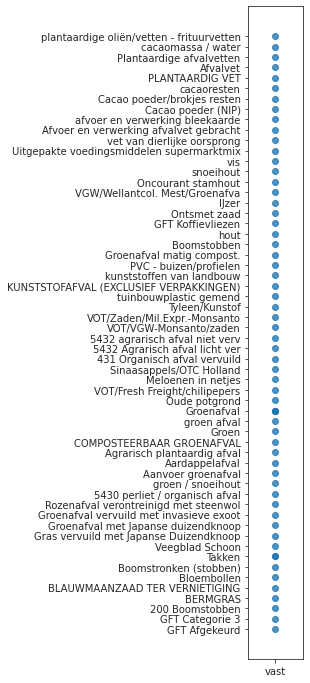

In [44]:
import seaborn as sns
import matplotlib.pyplot as plt

#chosen column field option
chosen_material = 'slakken'
chosen_mixedOrPure = 'puur'
chosen_consistency = 'vast'

# set graph: 
outcome = chosen_consistency
x_axis = 'consistency'
x_data = df.consistency

data = df.head(80).loc[x_data ==outcome]
sns.set_style('ticks')
fig, ax = plt.subplots()
fig.set_size_inches(1, 12)
sns.regplot(x=x_axis, y='description', data=data, ax=ax)
